# CASE STUDY

## CODE

### 1)Import Packages

In [1]:
import pypsa
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import warnings
import subprocess
from shapely.errors import ShapelyDeprecationWarning
import logging

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("pypsa.pf").setLevel(logging.WARNING)
plt.rc("figure", figsize=(10, 8))

In [2]:
excel_file_path = "C:\\Users\\dell\\Documents\\1\\data_germany_Ten + TransnetBW.xlsx"


### 2)Create a network and set Snapshots

In [3]:
# Create a new PyPSA network
network= pypsa.Network()
network.set_snapshots(range(8760))  # Solve for a year 365*24

### 3)Add Buses

In [4]:
# Read excel file which contains Non renewable generators data
bus_data = pd.read_excel(excel_file_path, sheet_name='buses')

In [5]:
for index,row in bus_data.iterrows():
    network.add(
    "Bus",
    name=row['bus'],
    v_nom=row['v_nom'],
    carrier=row['carrier'],
    x=row['x'],
    y=row['y']
)
    
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
Tennet,380.0,,9.993682,53.551086,AC,,1.0,0.0,inf,PQ,,
TransnetBW,380.0,,9.057645,48.521637,AC,,1.0,0.0,inf,PQ,,


### 4)Add generators

In [6]:
generators = pd.read_excel(excel_file_path,sheet_name="generators" )

network.madd(
"Generator",
    names= generators.generator,
    bus=list(generators.bus),
    carrier=list(generators.carrier),
    p_nom=list(generators.p_nom),      
    p_nom_max=list(generators.p_nom_A),     
    #p_nom_max=list(generators.p_nom_B),    
    #p_nom_max=list(generators.p_nom_C),    
    p_nom_extendable=list(generators.p_nom_extandable),
    marginal_cost=list(generators.marginal_cost),
    efficiency=list(generators.efficiency),
    capital_cost=list(generators.capital_cost)
    ) 

network.generators

,bus,carrier,p_nom,p_nom_max,p_nom_extendable,marginal_cost,efficiency,capital_cost,control,type,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
TBW_Biomasse,TransnetBW,biomass,926.0,700.0,False,74.520,0.40,220900.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
TBW_Coal,TransnetBW,coal,5331.0,2800.0,False,33.708,0.30,130000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
TBW_Lignite,TransnetBW,lignite,1167.0,0.0,False,31.960,0.40,190000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
TBW_Natural gas,TransnetBW,gas,1414.0,1000.0,False,36.568,0.40,40000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
TBW_Onshore Wind,TransnetBW,wind,1650.0,2800.0,True,0.000,1.00,118200.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
TBW_Pumped storage,TransnetBW,hydro,1500.0,1900.0,True,3.000,0.95,200000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
TBW_Solar,TransnetBW,solar,6532.0,9600.0,True,0.000,1.00,60000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
TBW_runofriver,TransnetBW,hydro,500.0,1000.0,True,3.000,0.94,90000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
TBW_therconventionals,TransnetBW,fuel,1167.0,100.0,False,35.000,0.30,100000.0,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [7]:
PV_timeseries=pd.read_excel(excel_file_path,sheet_name='PV_timeseries')
wind_timeseries=pd.read_excel(excel_file_path,sheet_name='wind_timeseries')

In [8]:
network.generators_t.p_max_pu["TBW_Solar"] = list(PV_timeseries.p_nom_pu_TransnetBW)
network.generators_t.p_max_pu["TBW_Onshore Wind"] = list(wind_timeseries.p_nom_pu_TransnetBW)

network.generators_t.p_max_pu["Ten_Solar"] = list(PV_timeseries.p_nom_pu_solar_Tennet)
network.generators_t.p_max_pu["Ten_Offshore Wind"] = list(wind_timeseries.p_nom_pu_offshore_Tennet)
network.generators_t.p_max_pu["Ten_Onshore Wind"] = list(wind_timeseries.p_nom_pu_onshore_Tennet)

### 5)Add load

### Added by Parag

In [9]:
'''
You can add your all loads in a timeseries in columns and add load using network.add function like mentioned in the following code:
To verify whether the timeseries of the load data (p_set) is added properly, use:  `network.loads_t.p_set`  this command
'''

"""
# Read excel file which contains Non renewable generators data
def add_consumers(filename, index_col):
    try:
        load = pd.read_(filename,index_col=index_col)
    except pd.errors.EmptyDataError:
        print("The CSV file is empty.")
        return

    for load_name in list(load.columns.unique()):
        network.add("Load",
        f"{load_name}",
        bus=load_name,
        p_set=load[load_name].tolist()
        )

    return network.loads_t.p_set.head(5)    
"""

'\n# Read excel file which contains Non renewable generators data\ndef add_consumers(filename, index_col):\n    try:\n        load = pd.read_(filename,index_col=index_col)\n    except pd.errors.EmptyDataError:\n        print("The CSV file is empty.")\n        return\n\n    for load_name in list(load.columns.unique()):\n        network.add("Load",\n        f"{load_name}",\n        bus=load_name,\n        p_set=load[load_name].tolist()\n        )\n\n    return network.loads_t.p_set.head(5)    \n'

In [10]:
demand = pd.read_excel(excel_file_path,sheet_name="load_hourly" )
'''
network.add("Load", "Tennet", bus="Tennet", p_set=demand["TenneT"])
network.add("Load", "TransnetBW", bus="TransnetBW", p_set=demand["TransnetBW"])
'''
#'''Scenario A
network.add("Load", "Tennet", bus="Tennet", p_set=demand["load_A_TenneT"])
network.add("Load", "TransnetBW", bus="TransnetBW", p_set=demand["load_A_TransnetBW"])
#'''

'''Scenario B
network.add("Load", "Tennet", bus="Tennet", p_set=demand["load_B_TenneT"])
network.add("Load", "TransnetBW", bus="TransnetBW", p_set=demand["load_B_TransnetBW"])
'''

'''Scenario C
network.add("Load", "Tennet", bus="Tennet", p_set=demand["load_C_TenneT"])
network.add("Load", "TransnetBW", bus="TransnetBW", p_set=demand["load_C_TransnetBW"])
'''

'Scenario C\nnetwork.add("Load", "Tennet", bus="Tennet", p_set=demand["load_C_TenneT"])\nnetwork.add("Load", "TransnetBW", bus="TransnetBW", p_set=demand["load_C_TransnetBW"])\n'

<Axes: xlabel='snapshot', ylabel='MW'>

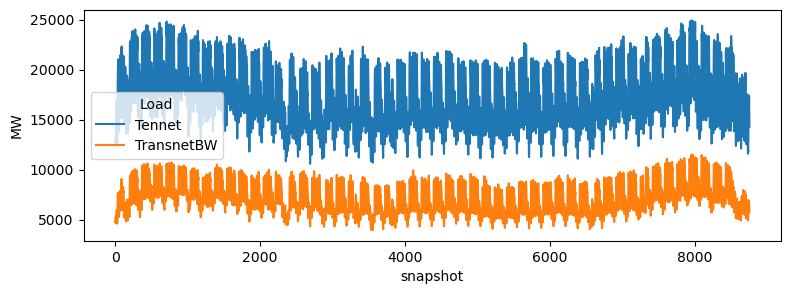

In [11]:
network.loads_t.p_set.plot(figsize=(9,3), ylabel="MW")

### 6)Add Lines

In [12]:
lines=pd.read_excel(excel_file_path,sheet_name='lines',header=0)
lines.head()

,name,bus0,bus1,s_nom,efficiency,s_nom_extendable
0,2,Tennet,TransnetBW,5000,1,True


In [13]:
for X, row in lines.iterrows():
    network.add("Line",
    name=row['name'],
    bus0=row['bus0'],
    bus1=row['bus1'],
    s_nom=row['s_nom'],
    x=row['efficiency'],
    s_nom_extendable=row['s_nom_extendable'] 
    )
network.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
2,Tennet,TransnetBW,,1.0,0.0,0.0,0.0,5000.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 7)Add links

links = pd.read_excel(excel_file_path, sheet_name='links')
links.head()

for X, row in links.iterrows():
    network.add("Link",
    name=row['name'],
    bus0=row['bus0'],
    bus1=row['bus1'],
    p_nom=row['p_nom'],
    p_nom_extendable=row['p_nom_extendable'],
    efficiency=row['efficiency'],
    capital_cost=row['capital_cost'] )
network.links

### 8)Add carriers

In [14]:
Carriers = pd.read_excel(excel_file_path,sheet_name="co2_emissions" )
Carriers.tail()

,name,co2_emissions
4,hydro,0.000
5,solar,0.000
6,biomass,0.000
7,fuel,0.202
8,reaction,0.000


In [15]:
for X, row in Carriers.iterrows():
    network.add(
        "Carrier",
        name=row['name'],
        co2_emissions=row['co2_emissions']
    )
network.carriers

attribute,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
coal,0.354,,,inf,0.0
gas,0.202,,,inf,0.0
lignite,0.364,,,inf,0.0
wind,0.000,,,inf,0.0
hydro,0.000,,,inf,0.0
solar,0.000,,,inf,0.0
biomass,0.000,,,inf,0.0
fuel,0.202,,,inf,0.0
reaction,0.000,,,inf,0.0


In [16]:
network.add("Store", "battery storage3", bus="Tennet", e_cyclic=True, e_nom=10000000.0)
network.add("Store", "battery storage4", bus="TransnetBW", e_cyclic=True, e_nom=10000000.0)

In [17]:
network.add(
    "StorageUnit",
    "battery storage3",
    bus="Tennet",
    p_nom=100000000,
    max_hours=10,  # energy storage in terms of hours at full power
)

In [18]:
network.add(
    "StorageUnit",
    "battery storage4",
    bus="TransnetBW",
    p_nom=100000000,
    max_hours=10,  # energy storage in terms of hours at full power
)

### 9)CO2 emissions

network.add("GlobalConstraint", "co2_limit", sense="<=", constant=438000000)

## RESULTS

### 1)Optimize

In [19]:
network.optimize(solver_name='glpk')

Index(['2'], dtype='object', name='Line')
Index(['2'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]
INFO:linopy.io: Writing time: 8.37s


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\dell\AppData\Local\Temp\linopy-problem-mohrreyj.lp --output
 C:\Users\dell\AppData\Local\Temp\linopy-solve-o5me9wz4.sol
Reading problem data from 'C:\Users\dell\AppData\Local\Temp\linopy-problem-mohrreyj.lp'...
648259 rows, 315371 columns, 1095895 non-zeros
3513726 lines were read
GLPK Simplex Optimizer 5.0
648259 rows, 315371 columns, 1095895 non-zeros
Preprocessing...
141038 rows, 263686 columns, 536990 non-zeros
Scaling...
 A: min|aij| =  1.396e-05  max|aij| =  1.000e+00  ratio =  7.161e+04
GM: min|aij| =  1.727e-01  max|aij| =  5.791e+00  ratio =  3.353e+01
EQ: min|aij| =  3.011e-02  max|aij| =  1.000e+00  ratio =  3.321e+01
Constructing initial basis...
Size of triangular part is 141038
      0: obj =   1.048300208e+10 inf =   6.119e+07 (17520)
    814: obj =   1.684820470e+10 inf =   5.748e+07 (17133) 1
   1665: obj =   1.674428827e+10 inf =   5.676e+07 (16905)
   2679: obj =   1.662977118e+

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 315371 primals, 648259 duals
Objective: 6.26e+08
Solver model: not available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

### 2)Margianl price

In [20]:
network.buses_t.marginal_price

Bus,Tennet,TransnetBW
snapshot,,
0,36.568,36.568
1,36.568,36.568
2,36.568,36.568
3,36.568,36.568
4,36.568,36.568
...,...,...
8755,36.568,36.568
8756,36.568,36.568
8757,36.568,36.568


<Axes: xlabel='Generator', ylabel='MW'>

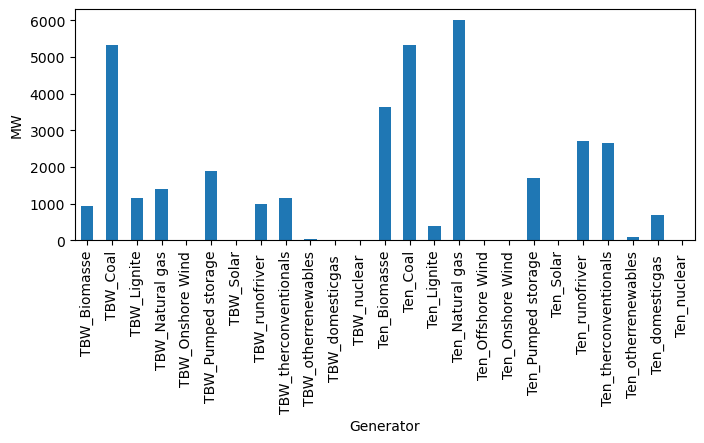

In [21]:
network.generators.p_nom_opt.plot.bar(ylabel="MW", figsize=(8, 3))

<Axes: xlabel='Generator', ylabel='Total generation MW'>

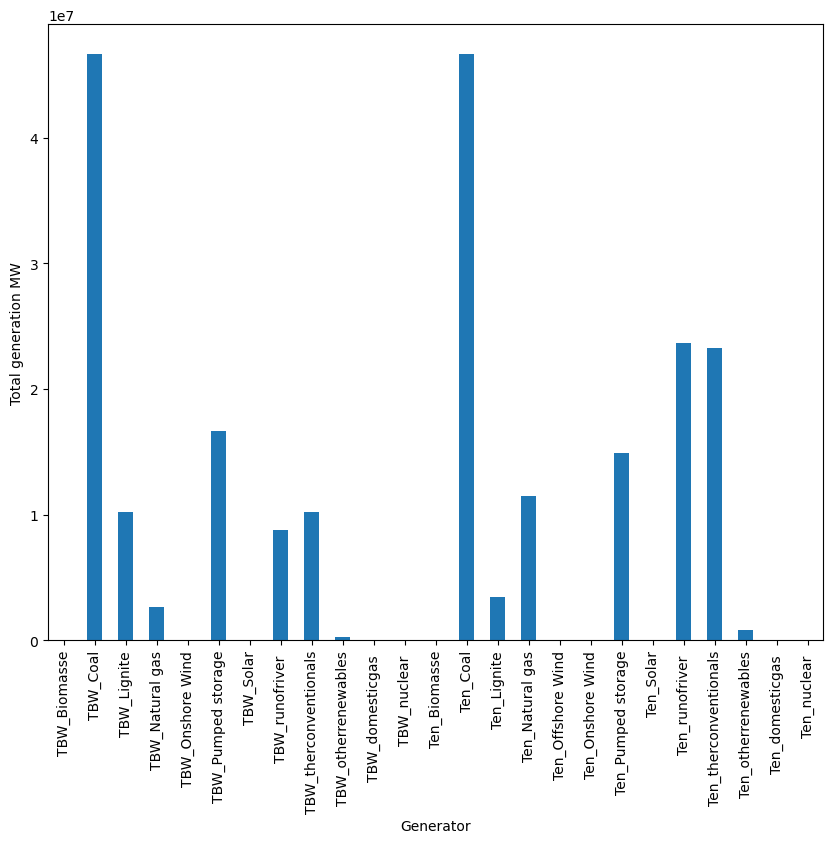

In [22]:
network.generators_t.p.sum().plot.bar(ylabel="Total generation MW")

### 3)Lines snapshot

In [23]:
network.lines_t.p0

Line,2
snapshot,
0,-376.875
1,-251088.000
2,-5812.880
3,-5865.200
4,-5780.700
...,...
8755,226204.000
8756,-2352.210
8757,-2095.360


### 4)Gen assign

In [24]:
gen = network.generators.assign(g=network.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()
gen

bus         carrier  
Tennet      biomass      6.970719e-13
            coal         5.331000e+03
            fuel         2.750000e+03
            gas          1.315838e+03
            hydro        4.400000e+03
            lignite      3.900000e+02
            reaction     0.000000e+00
            solar        0.000000e+00
            wind         0.000000e+00
TransnetBW  biomass      0.000000e+00
            coal         5.331000e+03
            fuel         1.201000e+03
            gas          2.993099e+02
            hydro        2.900000e+03
            lignite      1.167000e+03
            reaction     0.000000e+00
            solar        0.000000e+00
            wind         0.000000e+00
Name: g, dtype: float64

### 5)Flow

In [25]:
flow = pd.Series(10, index=network.branches().index)
flow

component  name
Line       2       10
dtype: int64

### 6)Geo. graph

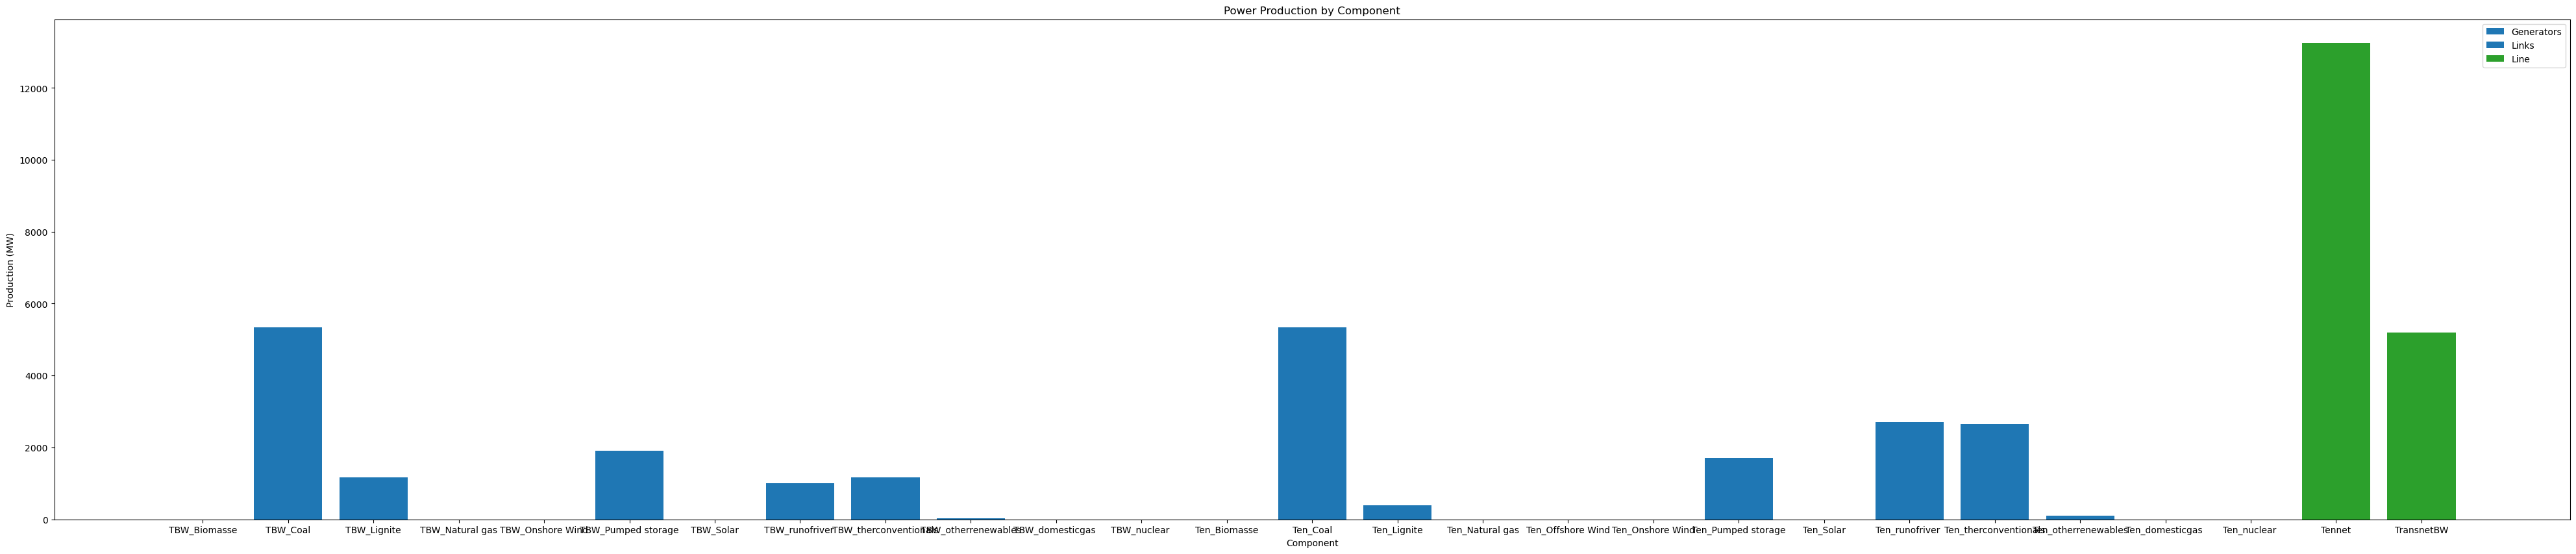

In [27]:
# Your DataFrame df
df = pd.concat(
    [
        network.generators_t.p.loc[0],
        network.links_t.p0.loc[0],
        network.loads_t.p.loc[0],
    ],
    keys=["Generators", "Links", "Line"],
    names=["Component", "index"],
).reset_index(name="Production")

# Plotting using PyPSA
fig, ax = plt.subplots(figsize=(50, 10))

# Plot generators
df_generators = df[df["Component"] == "Generators"]
ax.bar(df_generators["index"], df_generators["Production"], label="Generators")

# Plot links
df_links = df[df["Component"] == "Links"]
ax.bar(df_links["index"], df_links["Production"], label="Links")

# Plot loads
df_loads = df[df["Component"] == "Line"]
ax.bar(df_loads["index"], df_loads["Production"], label="Line")

# Customize the plot
ax.set_xlabel("Component")
ax.set_ylabel("Production (MW)")
ax.set_title("Power Production by Component")
ax.legend()

# Show the plot
plt.show()


## ADDITIONAL

### -)Storages

In [ ]:
"""
def add_stores(filename, header):
    try:
        stores = pd.read_csv(filename, header=header)
    except pd.errors.EmptyDataError:
        print("The CSV file is empty.")
        return
        
    for index, row in stores.iterrows():
        network.add(
            "Store",
            name=row['name'],
            e_initial=row['e_initial'],
            e_nom=row['e_nom'],
            marginal_cost=row['marginal_cost'],
            bus=row['bus'],
            e_cyclic=row['e_cyclic'],
            e_nom_extendable=row['e_nom_extendable'],
        )
    return network.stores
"""

add_stores('stores.csv',0)

### -)Global constraints

In [ ]:
#network.lopf()